In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Introduction

This notebook shows how to make streamline templates representing a group of track models for use with Recobundles (https://www.ncbi.nlm.nih.gov/pubmed/28712994), which is implemented in DIPY (http://nipy.org/dipy/)

# Setup

In [3]:
from glob import glob
from IPython.display import Image

In [4]:
import numpy as np
from nibabel import trackvis as tv
from dipy.segment.clustering import QuickBundles
from dipy.data import get_data
from dipy.viz import fvtk
import matplotlib as mpl
import seaborn as sns
import pickle

from dipy.tracking.streamline import length
from dipy.align.streamlinear import StreamlineLinearRegistration
#from streamlinear_kmjmod import StreamlineLinearRegistration
from dipy.tracking.streamline import set_number_of_points
import os

import sys

import nibabel as nib

from dipy.viz import window, actor
from dipy.viz.fvtk import camera

from dipy.tracking.distances import bundles_distances_mdf
from dipy.tracking.utils import move_streamlines

from dipy.align.streamlinear import whole_brain_slr

In [7]:
import kesh_autoseg_tools as kat

In [68]:
#Path to a whole-brain streamline dataset in MNI space
#https://figshare.com/articles/Simple_model_bundle_atlas_for_RecoBundles/6483614
MNI_wholebrain_trkfile_path = '/Users/kesshijordan/ref_data/Atlas_in_MNI_Space_16_bundles/whole_brain/whole_brain_MNI.trk'

#The Keystone subject will be used to map between your cohort and MNI space
Keystone_subject_wholebrain_trkfile_path = '/Users/kesshijordan/Desktop/IU_Bloomington/qb_templates/Base_CTRL/Whole_Brain_long_resaved_newapi.trk'
#Also include the bundle of interest (BOI) segmented in the Keystone subject
Keystone_subject_BOI_trkfile_path = '/Users/kesshijordan/Desktop/IU_Bloomington/qb_templates/Base_CTRL/Results/Arcuate_L.trk'

#These are the bundles that will be included in the template
BOI_list = glob('/Users/kesshijordan/ref_data/control_manual_data/*/Arcuate_L.trk')
BOI_list

['/Users/kesshijordan/ref_data/control_manual_data/C08/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C06/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C01/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C07/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C09/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C14/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C13/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C12/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C15/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C02/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C05/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C04/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C03/Arcuate_L.trk',
 '/Users/kesshijordan/ref_data/control_manual_data/C10/Arcuate_L.trk',
 '/Use

In [9]:
mni_tg, mni_hdr = kat.loadtgm_newapi(MNI_wholebrain_trkfile_path)
mni_sls = mni_tg.streamlines

In [10]:
key_tg, key_hdr = kat.loadtgm_newapi(Keystone_subject_wholebrain_trkfile_path)
key_sls = key_tg.streamlines

In [11]:
keystone_inMNI, transform_key2mni, qb_cents1, qb_cents2 = kat.rough_reg(mni_sls, key_sls)

Static streamlines size 144678
Moving streamlines size 108379
Static streamlines after length reduction 123874
Moving streamlines after length reduction 91351
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 231
QB moving centroids size 330
SLR finished in  8.155 seconds.
SLR iterations: 53 


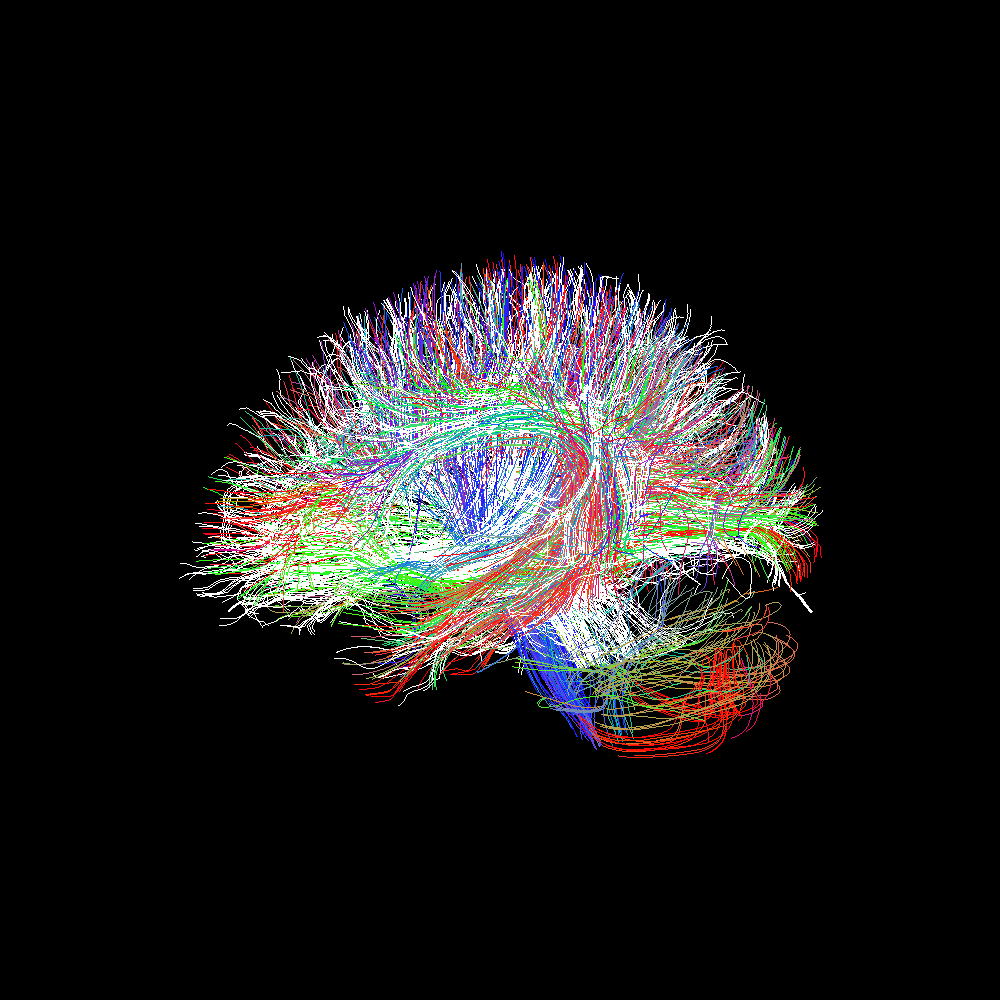

In [12]:
Image(kat.genren_AGG(mni_sls[::100], keystone_inMNI[::100], showme=True))

In [13]:
key_boi_tg, key_boi_hdr = kat.loadtgm_newapi(Keystone_subject_BOI_trkfile_path)
key_boi_sls = key_boi_tg.streamlines

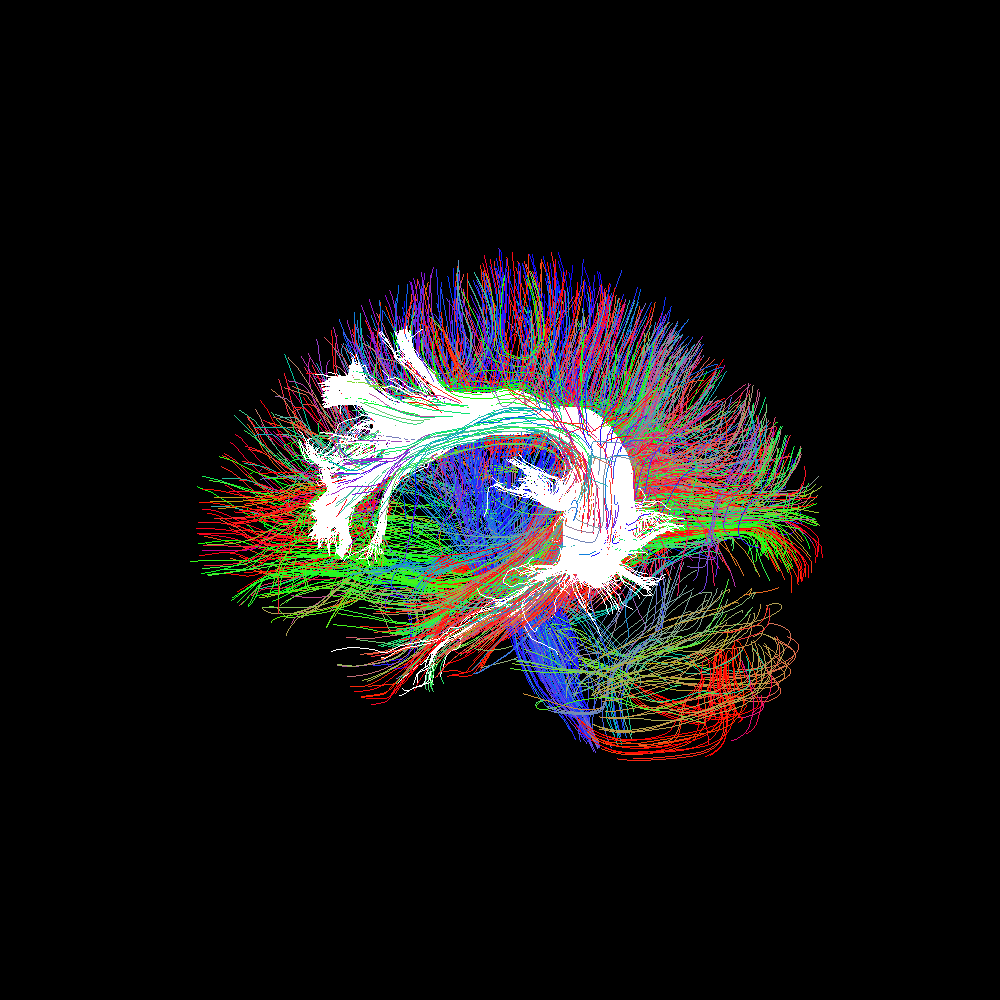

In [23]:
key_boi_in_mni = list(move_streamlines(key_boi_sls, transform_key2mni))
Image(kat.genren_AGG(mni_sls[::100], key_boi_in_mni, showme=True))

In [16]:
def load_trk_list(path_list):
    bundle_list = []
    for p in path_list:
        tg, hdr = kat.loadtgm_newapi(p)
        sls = tg.streamlines
        bundle_list.append(sls)
    return bundle_list

In [17]:
bundle_list = load_trk_list(BOI_list)

In [33]:
def show_bundle_list(bundles, showme=False, putpath='test.png'):
    colors = sns.color_palette("Set1", len(bundles)+1)
    ren = fvtk.ren()
    ren.SetBackground(1., 1, 1)
    for (i, bundle) in enumerate(bundles):
        color = colors[i]
        lines = fvtk.streamtube(bundle, color, linewidth=0.3)
        lines.RotateX(-90)
        lines.RotateZ(-90)
        fvtk.add(ren, lines)
    if showme:
        fvtk.show(ren)
    fvtk.record(ren, n_frames=1, out_path=putpath, size=(900, 900))
    return putpath

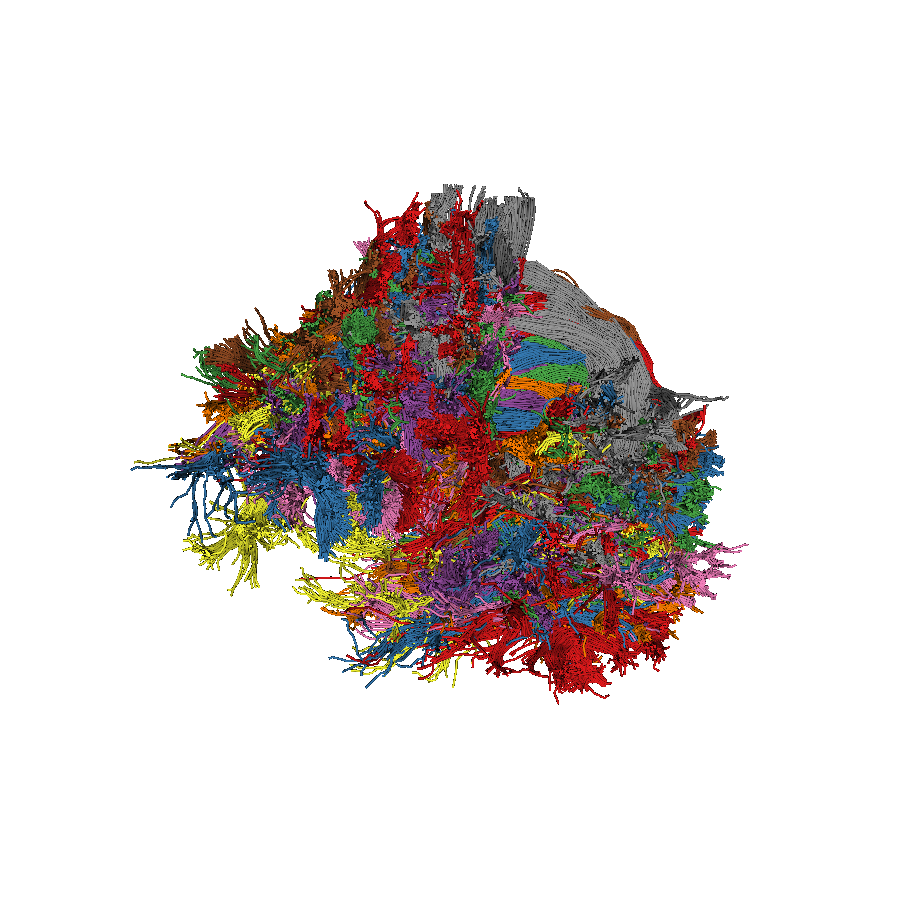

In [35]:
Image(show_bundle_list(bundle_list, showme=True))

In [19]:
def make_kesh_template(bundle_list, keystone_boi, qb_thresh=5., Nsubsamp=20, 
                       clsz_thresh=5, keystone2MNI_xfm=None, verbose=False):
    '''
    bundle_list: list of independent bundles (lists) not assumed to be in the same space
    keystone_boi: bundle (list) of streamlines that will be the anchor bundle all 
                  others are registered to for the template
    qb_thresh: threshold for quickbundle (determines how finely each bundle is clustered)
    Nsubsamp: subsampling for quickbundles and SLR
    clsz_thresh: how many streamlines a cluster must have to be included in the template*
    keystone2MNI_SLR: streamlinear registration between the whole brain keystone and MNI**
    verbose: if you want to print info about each bundle as it runs set this to True
    
    
    *qb_thresh adn clsz_thresh are related. If you have a fine parcellation 
    (low qb_thresh) then the clsz_threshold should be quite low since clusters 
    will be small.
    
    **PROVIDE THIS IF (and only if) YOU WANT THE RESULT TO BE IN MNI SPACE OTHERWISE
    IT WILL BE IN KEYSTONE SPACE
    '''
    
    kesh_template_sls=[]
    rejected_sls = []
    boi_sls_subsamp = set_number_of_points(keystone_boi, Nsubsamp)
    for i,sls in enumerate(bundle_list):
        print(len(bundle_list)-i)
        sls_subsamp = set_number_of_points(sls, Nsubsamp)
        qb = QuickBundles(threshold=qb_thresh)
        clusters = qb.cluster(sls)
        cluster_sizes = [len(cl) for cl in clusters]
        #enforce that clusters smaller than a threshold are not in template
        centroids = clusters.centroids
        slr = StreamlineLinearRegistration()
        srm = slr.optimize(static=boi_sls_subsamp, moving=sls_subsamp)
        xfmd_centroids = srm.transform(centroids)
        #NOTE: we actually want to upsample the centroids so the template has 
        #better properties... what's the most efficient way to do that?
        for j,b in enumerate(xfmd_centroids):
            if cluster_sizes[j] < clsz_thresh:
                rejected_sls.append(xfmd_centroids.pop(j))
        kesh_template_sls+=xfmd_centroids
        if verbose:
            print('Bundle %i' % i)
            print('N centroids: %i' % len(centroids))
            print('kept %i rejected %i total %i' % (len(kesh_template_sls), 
                                                    len(rejected_sls), len(clusters)))
    if keystone2MNI_xfm:
        print('MNI YAY!')
    return kesh_template_sls, rejected_sls


In [20]:
template_sls, rejected_sls = make_kesh_template(bundle_list, key_boi_sls)

20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [21]:
template_sls_mni = list(move_streamlines(template_sls, transform_key2mni))

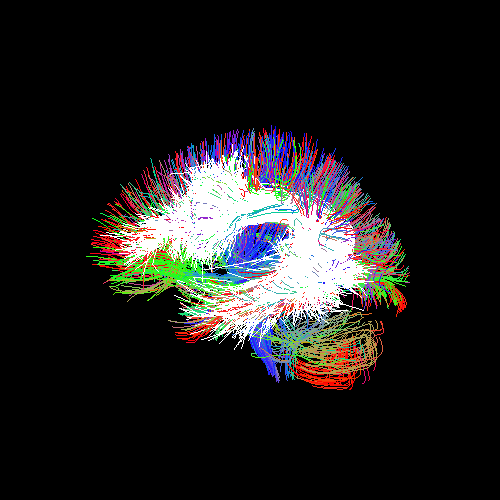

In [22]:
Image(kat.genren_AGG(mni_sls[::100], template_sls_mni, showme=True))

In [28]:
template_tgm_mni = nib.streamlines.tractogram.Tractogram(streamlines=template_sls_mni, affine_to_rasmm=mni_tg.affine_to_rasmm)

In [31]:
nib.streamlines.save(template_tgm_mni, 'testing_arcuate_template_raw.trk')

# Calculate outlier metric (CCI)

https://onlinelibrary.wiley.com/doi/abs/10.1111/jon.12467

In [32]:
def calculate_cci(streamlines, max_mdf=5, subsample=12, power=1):
    '''THIS IS IN A WIP PR'''
    #remove any streamlines that are shorter than the min_sl_length
    lengths = list(length(streamlines))
    if np.array(lengths).min()<20:
        print('Check your streamline lengths. There are many short streamlines!')

    #calculate the pairwise MDF distance between all streamlines in dataset that are longer than min_sl_length
    subsamp_sls = set_number_of_points(streamlines, subsample)

    cci_score_mtrx = np.zeros([len(subsamp_sls)])

    for i,sl in enumerate(subsamp_sls):
        mdf_mtrx = bundles_distances_mdf([subsamp_sls[i]], subsamp_sls)
        mdf_mtrx_oi = (mdf_mtrx > 0) & (mdf_mtrx < max_mdf) & ~ np.isnan(mdf_mtrx)
        mdf_mtrx_oi_only = mdf_mtrx[mdf_mtrx_oi]
        cci_score = np.sum(np.divide(1, np.power(mdf_mtrx_oi_only, power)))
        cci_score_mtrx[i] = cci_score

    return cci_score_mtrx

In [36]:
ccis = calculate_cci(template_sls_mni)

In [54]:
def showsls(sls, sl_value_vector=None, out_path='temp_cci.png', cmap_max=None, showme=False):
    
    renderer = window.Renderer()
    
    if sl_value_vector is not None:

        hue = [0.5, 1]
        saturation = [0.0, 1.0]
        
        if cmap_max is None:
            cmap_max = sl_value_vector.max()

        lut_cmap = actor.colormap_lookup_table(
            scale_range=(sl_value_vector.min(), cmap_max),
            hue_range=hue,
            saturation_range=saturation)

        bar3 = actor.scalar_bar(lut_cmap)
        renderer.add(bar3)

        stream_actor = actor.line(sls, sl_value_vector, linewidth=0.1,
                                   lookup_colormap=lut_cmap)
    else:
        stream_actor = actor.line(sls, linewidth=0.1)
    

    renderer.add(stream_actor)
    
    if showme:
        window.show(renderer, size=(600, 600), reset_camera=False)
    window.record(renderer, out_path=out_path, size=(600, 600))
    return out_path

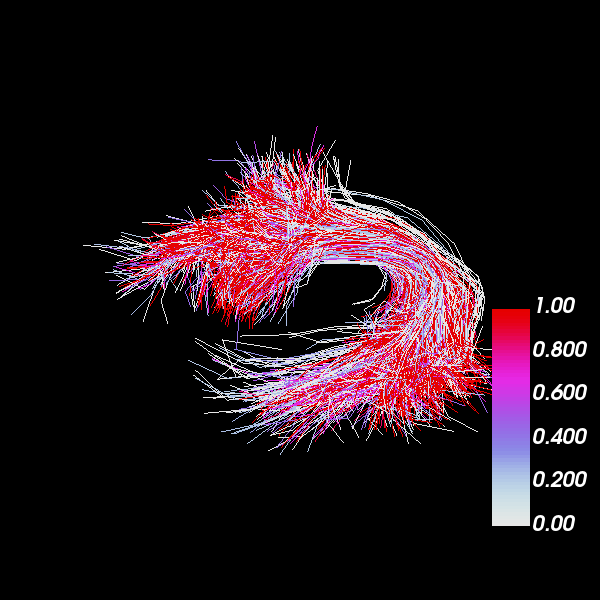

In [60]:
Image(showsls(template_sls_mni, ccis, cmap_max=1, showme=True))

## Threshold CCI at desired level

In [70]:
def filter_cci(sls, cci_vector, thr=1):
    new_sls = []
    rejected = []
    for i, sl in enumerate(sls):
        if cci_vector[i]>thr:
            new_sls.append(sl)
        else:
            rejected.append(sl)
    return new_sls, rejected

In [71]:
cci_sls, cci_reject = filter_cci(template_sls_mni, ccis, thr=0.5)

## Kept (red) & Rejected (blue)

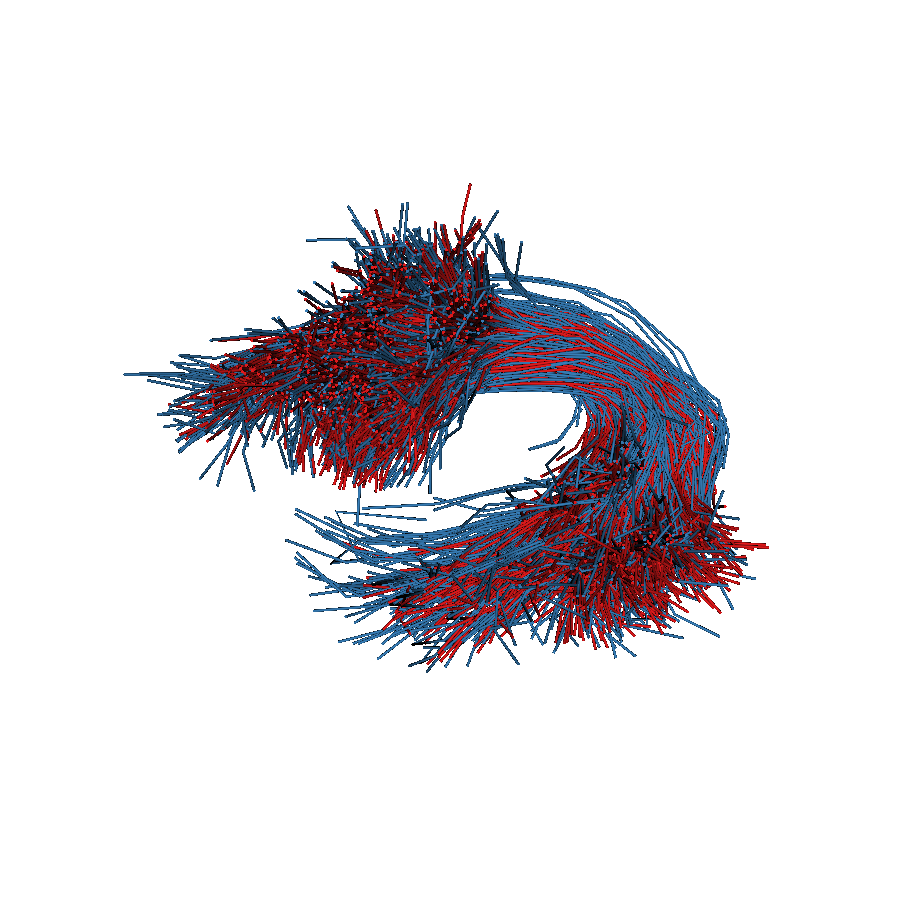

In [74]:
Image(show_bundle_list([cci_sls, cci_reject], showme=True))

## Final Template

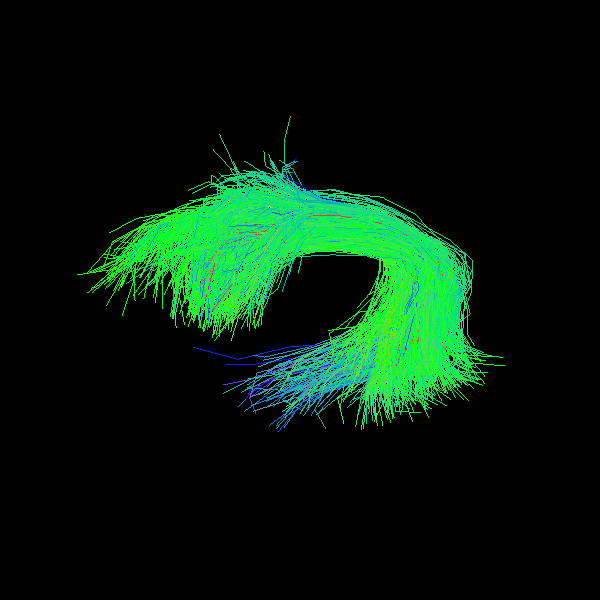

In [67]:
Image(showsls(cci_sls, showme=True))

# Human QC'd

As the last step, manually remove any bundles that are undesirable based on anatomical priors